# KORONAVIRUS

U jeku nove epidemije naše su misli cijeli dan, svaki dan, usmjerene na nove vijesti o stanju u državi i svijetu, broju zaraženih, oporavljenih i preminulih od nove bolesti. Budući da su svi ti podatci danas lako dostupni (a medicina je iznimno zanimljiva za proučavanje s matematičke točke gledišta), u ovom ćemo radu promatrati i analizirati te podatke.

## Što je koronavirus?

Par činjenica unijeti, ne previše, ali ipak da znamo što je.

## Analiza podataka

Podatci su preuzeti sa stranice https://data.europa.eu/euodp/hr/data/dataset/covid-19-coronavirus-data i spremljeni u datoteku imena (zasad) `preuzmi.csv`. <br><br>
Podatci u tablici su sljedeći:<br><br>
```
    1. dateRep = promatrani datum u formatu 'dd/mm/gggg'
    2. day = broj dana u promatranom datumu
    3. month = broj mjeseca u promatranom datumu
    4. year = broj godine u promatranom datumu
    5. cases = broj novozaraženih na promatrani dan
    5. deaths = broj preminulih na promatrani dan
    6. countriesAndTerritories = naziv države
    7. geoId = iso kod države (alpha 2)
    8. countryterritoryCode = iso kod države (alpha 3)
    9. popData2018 = ukupan broj populacije iz 2018. za promatranu državu
```
<br>
Prije nego što krenemo prikazivati tablice i analizirati podatke, prvo želimo tablicu <i>srediti</i>. Vidimo odmah da u ovoj tablici ima redundancija (datumi) i nama nebitnih podataka (iso kodovi) pa ćemo prije svega uključiti potrebne biblioteke i riješiti se tih problema (pa usto i preimenovati preostajeće podatke u nešto <i>ljepše</i>).

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('preuzmi.csv', encoding='utf-8')
data = data.rename(columns={'dateRep': 'Date', 'cases': 'Cases', 'deaths': 'Deaths', 'countriesAndTerritories': 'Country', 'popData2018': 'Population'})
data['Date'] = pd.to_datetime(dict(year=data['year'], month=data['month'], day=data['day']))
del data['day'], data['month'], data['year'], data['geoId'], data['countryterritoryCode']
data = data[::-1]

data.head()

,Date,Cases,Deaths,Country,Population
11357,2020-03-21,1,0,Zimbabwe,14439018.0
11356,2020-03-22,1,0,Zimbabwe,14439018.0
11355,2020-03-23,0,0,Zimbabwe,14439018.0
11354,2020-03-24,0,1,Zimbabwe,14439018.0
11353,2020-03-25,0,0,Zimbabwe,14439018.0


Sad možemo pogledati grafički prikaz razvoja epidemije.<br>
Prije svega ćemo prikazati kretanje broja zaraženih:

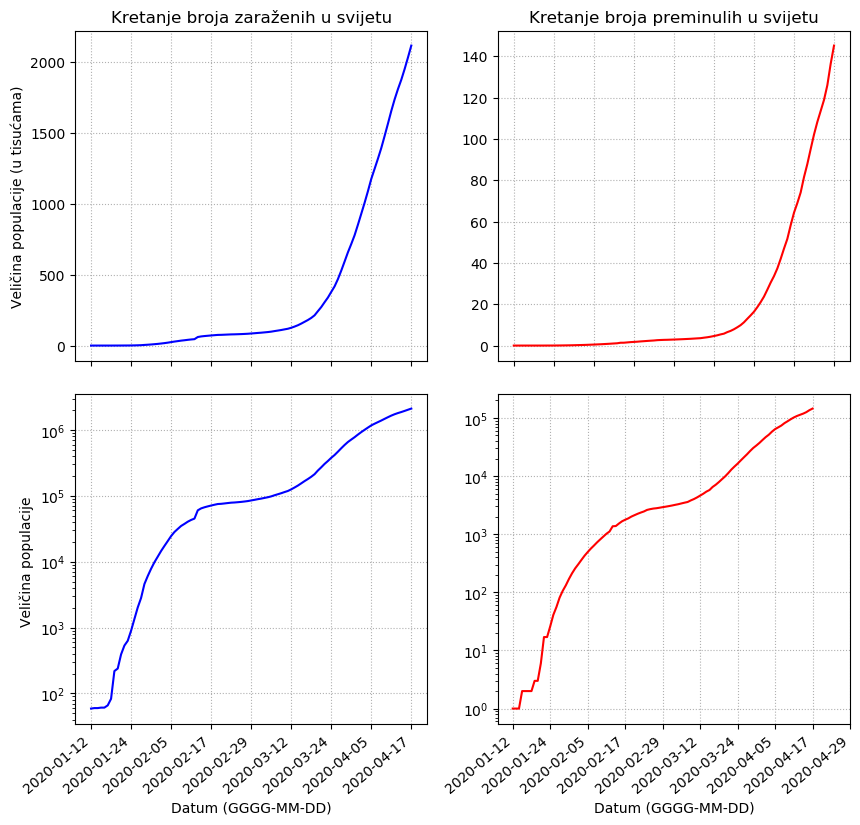

In [2]:
import datetime as dt
from functools import lru_cache
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 50
%matplotlib agg

@lru_cache()
def izdvoji_državu(država):
    if država == 'World': return izdvoji_državu('China')
    return data[data['Country'] == država]

def ukupno_dnevno_stanje(argument):
    lista=[]
    suma = 0
    for broj in data.groupby(['Date']).sum()[argument]:
        suma += broj
        lista.append(suma)
    return lista

def lista_dnevno_stanje(država, argument):
    if država == 'World': return ukupno_dnevno_stanje(argument)
    lista = []
    i=-1
    for dnevno_stanje in np.array(izdvoji_državu(država)[argument]):
        if i==-1: lista.append(int(dnevno_stanje))
        else: lista.append(int(dnevno_stanje)+lista[i])
        i +=1
    return lista

pridjevi = {'Cases': 'zaraženi', 'Deaths':'preminuli', 0:'Cases', 1:'Deaths'}
skale = {0:'linear', 1:'log'}
boje = {0:'blue', 1:'red'}
jedinica = {0:1000, 1:1, 2:'(u tisućama)', 3: ''}
države = {država:'državi: \n'+ država.replace('_', ' ') for država in data['Country'].drop_duplicates()}
države['World'] = 'svijetu'

def prikaz_kontinuiranog_stanja(država):
    #n = (dt.datetime(2020, 4, 17)-dt.datetime(2019, 12, 31)).days
    #base =dt.datetime(2019, 12, 31)
    dates = np.array(izdvoji_državu(država)['Date'])
    k = 0
    for broj in izdvoji_državu(država)['Cases']: 
        if broj == 0: k += 1
    if k > 2: k -= 2
    n = dates[k:].shape[0]//8
    base = dates[k]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 10)])
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, squeeze=True, figsize=(10, 9), gridspec_kw=dict(hspace=0.1))
    plt.xticks(rotation=40, ha='right')
    for i in range (0, 2):
        for j in range (0, 2):
            ax[i][j].plot(dates[k:], np.array(lista_dnevno_stanje(država, pridjevi[j]))[k:]/jedinica[i], color=boje[j])     
            ax[0][j].set_title('Kretanje broja ' + pridjevi[pridjevi[j]] + 'h u ' + države[država], fontsize='large')
            ax[i][0].set_ylabel('Veličina populacije ' + jedinica[i+2])
            ax[1][j].set_xlabel('Datum (GGGG-MM-DD)', fontsize='medium')
            ax[i][j].set_yscale(skale[i])
            plt.setp( ax[i][j].xaxis.get_majorticklabels(), rotation=40, ha='right')
            ax[i][j].set_xticks(dates2)
            ax[i][j].grid(linestyle = ':')
    return fig

prikaz_kontinuiranog_stanja('World')

Želimo (uredno) prikazati kretanje broja zaraženih i preminulih od virusa i po državama, ne samo u svijetu.

Također nam je korisno uspoređivati podatke u raznim državama:

In [3]:
def pripremi_podatke(država, argument):
    dates = np.array(izdvoji_državu(država)['Date'])
    n = dates.shape[0]//10
    base = dates[0]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    return [dates, dates2]
#još jedna pomoćna funkcija za bolju organizaciju podataka

def usporedba(lista):
    brojevi = np.array([izdvoji_državu(država)[izdvoji_državu(država)['Cases']>=0].shape[0] for država in lista])
    broj = brojevi.max()
    k = 0
    for temp in brojevi:
        if broj == temp: break;
        k += 1
    fig, ax = plt.subplots(1, 2, sharex=True, squeeze=True, figsize=(10, 5), gridspec_kw=dict(hspace=0.1))
    for i in range (0, 2):
        datumi = pripremi_podatke(lista[k], pridjevi[i])
        duljina = datumi[0].shape[0]
        for država in lista:
            nova = lista_dnevno_stanje(država, pridjevi[i])[::-1]
            while len(nova) < duljina: nova.append(0)
            ax[i].plot(datumi[0], nova[::-1]/(np.array(izdvoji_državu(država)['Population'])[0]/100), label = država)
            #ax[i][j].plot(dates[k:], np.array(lista_dnevno_stanje(država, pridjevi[j]))[k:]/jedinica[i], color=boje[j])     
            ax[i].set_title('Usporedba kretanja broja ' + pridjevi[pridjevi[i]] + 'h', fontsize='large')
            ax[i].set_xlabel('Datum (GGGG-MM-DD)', fontsize='medium')
            plt.setp( ax[i].xaxis.get_majorticklabels(), rotation=40, ha='right')
            ax[i].set_xticks(datumi[1])
            ax[i].grid(linestyle = ':')
    ax[0].set_ylabel('Udio zaraženih (%)')
    ax[0].legend(loc = 'best')  
    return fig

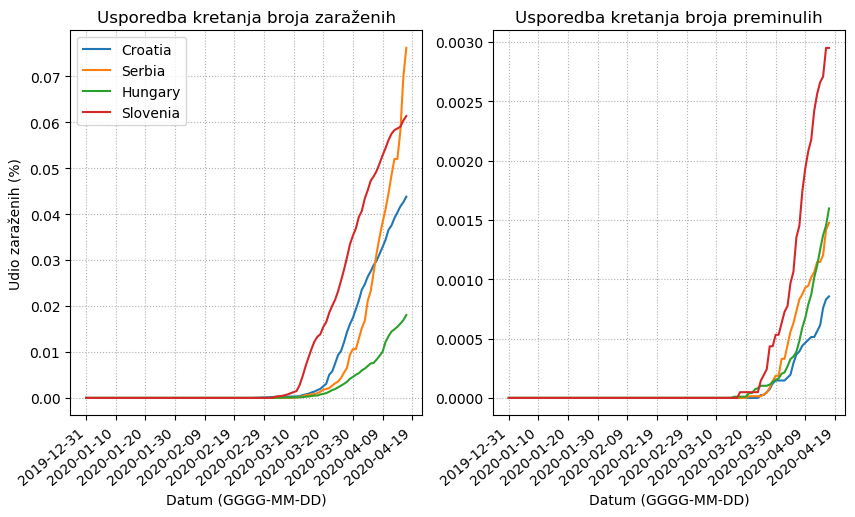

In [4]:
usporedba(['Croatia', 'Serbia', 'Hungary', 'Slovenia'])

Mala napomena: pri usporedbi kretanja broja preminulih osoba bi bilo idealno gledati udio preminulih u neaktivnim slučajevima. Međutim, budući da u tablici nemamo taj podatak (ili broj ozdravljenih), onda ćemo gledati udio preminulih u ukupnoj populaciji.

## Predviđanje daljnjeg razvoja epidemije

Naravno, nas ne zanima isključivo trenutno stanje, već nas zanima možemo li <i>predvidjeti</i> daljnji tijek ove epidemije?<br>
Odgovor: <b>linearna regresija</b>.<br><br>
<i>Slijedi pojašnjenje što je linearna regresija i metoda najmanjih kvadrata i na koji način to ovdje koristimo, nadodat ću tekst naknadno...</i><br><br>
Maločas navedenom metodom možemo procijeniti mogući tijek epidemije (na primjer, za Hrvatsku): <br><br>
Ovdje imamo dva očita problema korištenja linearne regresije:
<lu>
    <li>U stvarnosti je rast rijetko gdje doista eksponencijalan, prije svega jer su nadležne vlasti reagirale relativno pravodobno i učile na dosadašnjim greškama ostalih nacija (jedan relativno dobar primjer je dakako i Hrvatska).</li>
    <li>Na mjestima gdje rast u početku i jest eksponencijalan, obično se on vrlo brzo stavi pod kontrolu pa nam funkcija dobivena ovom metodom više puno i ne koristi (npr. trenutno nam nema smisla na ovaj način proučavati podatke u Kini).</li>
</lu>

In [5]:
import statsmodels.api as sm

def pomoćni_ln(broj):
    if broj == 0: return 0
    else: return float(np.log(broj))

lnn = np.vectorize(pomoćni_ln, otypes=[np.float])

def vrati_procjenu(a, b):
    return lambda x: (np.e**a)*((np.e**b)**x)

def podatci_graf_regresija(država):
    dates = np.array(izdvoji_državu(država)['Date'])
    broj_dana = 0
    while np.array(izdvoji_državu(država)[izdvoji_državu(država)['Date']<=dates[broj_dana]]['Cases']).sum()==0:
        broj_dana += 1
    if broj_dana > 2: broj_dana -= 2
    brojač_dana = [i for i in range(0, dates.shape[0]-broj_dana)]
    brojač_dana2 = sm.add_constant(brojač_dana)
    zaraza = lnn(np.array(lista_dnevno_stanje(država, 'Cases'))[broj_dana:])
    model = sm.OLS(zaraza, brojač_dana2)
    rez = model.fit()
    print(rez.summary())
    funkcija = vrati_procjenu(rez.params[0], rez.params[1])
    n = dates[broj_dana:].shape[0]//10
    base = dates[broj_dana]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    #također ne želimo da nam se prikaže apsolutno svaki datum jer je to nepregledno
    fig, ax = plt.subplots()
    ax.plot(dates[broj_dana:], lista_dnevno_stanje(država, 'Cases')[broj_dana:], label = 'Pravi brojevi')
    ax.plot(dates[broj_dana:], np.vectorize(funkcija)(brojač_dana), label = 'Procjena')
    plt.xticks(rotation=40, ha='right')
    ax.set_xticks(dates2)
    ax.set_title('Stvarni brojevi i dobiveni pomoću OLS u državi: ' + država.replace('_', ' '))
    ax.set_ylabel('Broj zaraženih')
    ax.set_xlabel('Datum (GGGG-MM-DD)')
    ax.legend(loc = 'best')
    plt.grid(linestyle = ':')
    return [fig, funkcija]

Primjer kada nam linearna regresija i može reći kako se podatci mogu dalje kretati jest SAD, jer je rast ondje i dalje eksponencijalan:

In [6]:
podatci_SAD = podatci_graf_regresija('Russia')
funkcija_SAD = podatci_SAD[1]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     638.6
Date:                Fri, 17 Apr 2020   Prob (F-statistic):           1.58e-37
Time:                        19:34:49   Log-Likelihood:                -113.32
No. Observations:                  74   AIC:                             230.6
Df Residuals:                      72   BIC:                             235.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7424      0.261     -6.674      0.0

<i>Slijedi interpretacija dobivenih podataka...</i><br><br>
Pogledajmo i grafički prikaz stvarnih podataka i dobivenih ovom metodom:

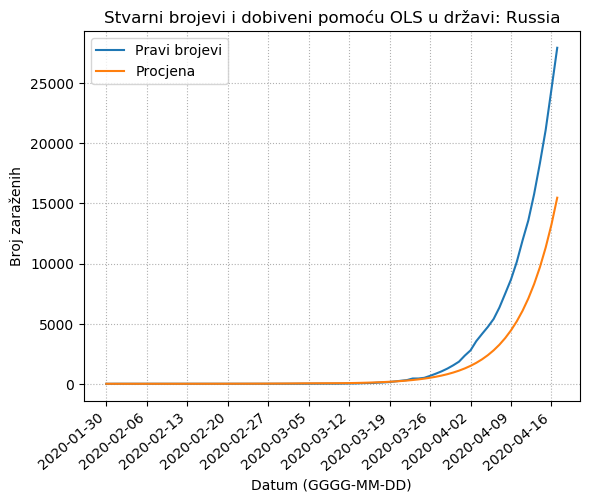

In [7]:
podatci_SAD[0]

Sad možemo i procijeniti mogući broj zaraženih na određeni dan; na primjer, broj zaraženih dana 20. travnja 2020. mogao bi biti $1826126$.

In [8]:
int(round(funkcija_SAD((dt.datetime(2020, 4, 20)-dt.datetime(2020, 1, 19)).days)))

299857

Kao što sam naveo prije, u Hrvatskoj nam ova metoda ne pruža mnogo korisnih podataka jer rast nije eksponencijalan. Jasno vidimo da stoga ovaj rezultat nije egzaktan, pa niti daljnje procjene ne možemo prihvatiti s nekom pouzdanošću.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     819.0
Date:                Fri, 17 Apr 2020   Prob (F-statistic):           3.04e-32
Time:                        19:34:50   Log-Likelihood:                -43.612
No. Observations:                  51   AIC:                             91.22
Df Residuals:                      49   BIC:                             95.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8136      0.160      5.078      0.0

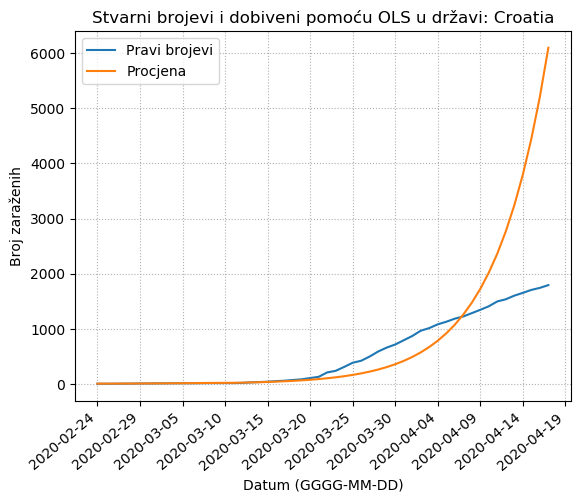

In [9]:
podatci_RH = podatci_graf_regresija('Croatia')
funkcija_RH = podatci_RH[1]
podatci_RH[0]

Za primjer, ova nam procjena kaže da bismo za šest dana, 20. travnja 2020. trebali imati čak $15427$ zaraženih, što je vrlo malo vjerojatan scenarij:

In [10]:
int(round(funkcija_RH((dt.datetime(2020, 4, 20)-dt.datetime(2020, 2, 27)).days)))

9800

## Epidemiološki modeli

Ideja za nastavak rada bi bila proučiti relevantne epidemiološke modele za infektivne bolesti.<br>
Modeli se temelje na pretpostavci da imamo tri grupe ljudi:<br><br>
<lu>
    <li>oni koji su podložni bolesti (<i>susceptible</i>)</li>
    <li>širitelji zaraze (<i>infectious</i>)</li>
    <li>oporavljeni (<i>recovered</i>)</li>
</lu><br><br>
Ovisno o mogućnosti prijelaza imamo dva osnovna modela (koja bismo htjeli promatrati):<br><br>
<lu>
    <li> SIR - mogući su prijelazi iz podložnog bolesti u širitelj zaraze, te iz širitelja zaraze u oporavljenog, ali je glavna pretpostavka da se ljudi koji se oporave više ne mogu zaraziti</li>
    <li> SIRS - za razliku od SIR modela, ovdje se pretpostavlja da ljudi nakon što se oporave mogu opet biti podložni zarazi</li>
</lu>

<b>NAPOMENE I IDEJE</b>:<br><br>
<lu>
    <li>Paziti da ovo doista bude priča, a ne samo crtanje lijepih grafova u raznim bojama!</li>
    <li>Sve dosadašnje sekcije nadopuniti konkretnim tekstom i pojašnjenjima što se zapravo događa i što radimo.</li>
    <li>Bilo bi zgodno prilagoditi dosadašnje funkcije tako da nemamo razdvojeni prikaz broja zaraženih i preminulih nego da ta dva grafa budu <i>side-by-side</i>.</li>
    <li>Mogućnost ubacivanja histograma koji bi prikazivao broj novozaraženih po danima.</li>
    <li>Možda kakav 3D graf? Ili animacija? </li>
    <li>Poseban fokus staviti na Hrvatsku i njezine brojke. Prikupiti dodatne podatke o kretanju broja oporavljenih (tj. stranice koronavirus.hr) i prikazati ih.</li>
    <li>Nadalje razviti sekciju o epidemiološkim modelima.</li>
    <li>Urediti kod: prilagoditi imena varijabli (da nemamo bilingvalne nazive), riješiti redundancije u kodu (<u>a ima ih</u>) uvođenjem još nekih pomoćnih funkcija. </li>
</lu>